In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
#################
# generating data

f = lambda x: x**2 / 3 - 3 * x * np.sin(x-2) - np.cos(x)
m = lambda x: np.zeros_like(x)

#################

In [89]:
def compute_post(grid_x, m, observed_x, observed_f, k_rbf, sigma_rbf):
    
    # grid_x: the set of points we want to compute the posterior distribution
    # m: m(x) returns the prior guess
    # observed_x: observed points
    # observed_f: function value of observed points
    # k_rbf, sigma_rbf: parameters of RBF kernel
    
    # return mu_x, sigma_x: mean and variance of grid_x
    
    oxox_rbf = np.linalg.inv(k_rbf * np.exp(-np.abs(observed_x[:, np.newaxis] - observed_x[np.newaxis, :])**2 / (2*sigma_rbf**2)))
    gxox_rbf = (k_rbf * np.exp(-np.abs(observed_x[:, np.newaxis] - grid_x[np.newaxis, :])**2 / (2*sigma_rbf**2)))
    gxgx_rbf = (k_rbf * np.exp(-np.abs(grid_x[:, np.newaxis] - grid_x[np.newaxis, :])**2 / (2*sigma_rbf**2)))
    
    mu_x = m(grid_x) + gxox_rbf.T @ oxox_rbf @ (observed_f - m(observed_x))
    
    
    sigma_x = np.sqrt(np.maximum(0, np.diag(gxgx_rbf) - np.sum(gxox_rbf * (oxox_rbf @ gxox_rbf), axis = 0)))
    
    
    return mu_x, sigma_x
    

In [12]:
def EI(f_star, mu_x, sigma_x, grid_x):
    
    # f_star: best value observed so far
    # grid_x: the set of points we want to compute the expected improvement
    # mu_x, sigma_x: mean and variance of grid_x
    
    # return EI_x: expected improvement at grid_x
    
    EI_x = np.zeros_like(grid_x)
    for i in range(len(grid_x)):
        
        if np.abs(sigma_x[i]) < 1e-8:
            EI_x[i] = np.maximum(0, f_star - mu_x[i])
        else:
            EI_x[i] = (f_star - mu_x[i]) * norm.cdf((f_star - mu_x[i])/sigma_x[i]) + sigma_x[i] / np.sqrt(2*np.pi) * np.exp(-(f_star - mu_x[i])**2/(2*sigma_x[i]**2))
    
    return EI_x

In [5]:
def LCB(f_star, mu_x, sigma_x, grid_x, beta):
    
    # f_star: best value observed so far
    # grid_x: the set of points we want to compute the lower confidence bound
    # mu_x, sigma_x: mean and variance of grid_x
    
    # return LCB_x: (negative) lower confidence bound at grid_x
    
    LCB_x = beta * sigma_x -  mu_x  
    
    return LCB_x

In [94]:
def Bayesian_EI(max_iter = 20, k_rbf=1, sigma_rbf=1, grid_range = [-10,10], grid_freq = 0.1):
    
    # max_iter: maximum number of iteration
    # k_rbf, sigma_rbf: parameters of RBF kernel
    # grid_range, grid_freq: setting the grid
    
    
    # grid of x
    grid_x = np.arange(grid_range[0], grid_range[1], grid_freq)
    
    # initialize observed set
    observed_x = np.array([grid_x[int(len(grid_x)/2)]])
    
    # record which points have been queried
    observed_index = np.zeros_like(grid_x, dtype="int")
    observed_index[int(len(grid_x)/2)] = 1
    
    # record mu and sigma at each iteration
    mu_trajectory = np.zeros((len(grid_x),max_iter))
    sigma_trajectory = np.zeros((len(grid_x),max_iter))
    
    for i_iter in range(max_iter):
        
        
        mu_x, sigma_x = compute_post(grid_x, m, observed_x, f(observed_x), k_rbf, sigma_rbf)
        EI_x = EI(np.min(f(observed_x)), mu_x, sigma_x, grid_x)
        
        # avoid choosing the same point

        EI_x[observed_index==1] = -1e10
        query_index = np.argmax(EI_x)
        observed_index[query_index] = 1
        x_query = grid_x[query_index]
        observed_x = np.hstack([observed_x, x_query])
        
        mu_trajectory[:,i_iter] = mu_x
        sigma_trajectory[:,i_iter] = sigma_x
        
        
    return observed_x, mu_trajectory, sigma_trajectory
        
        

In [86]:
def Bayesian_LCB(max_iter = 20, k_rbf=1, sigma_rbf=1, beta = 1, grid_range = [-10,10], grid_freq = 0.1):
    
    # max_iter: maximum number of iteration
    # k_rbf, sigma_rbf: parameters of RBF kernel
    # beta: beta in LCB 
    # grid_range, grid_freq: setting the grid
    
    
    # grid of x
    grid_x = np.arange(grid_range[0], grid_range[1], grid_freq)
    
    # initialize observed set
    observed_x = np.array([grid_x[int(len(grid_x)/2)]])
    
    # record which points have been queried
    observed_index = np.zeros_like(grid_x)
    observed_index[int(len(grid_x)/2)] = 1
    
    # record mu and sigma at each iteration
    mu_trajectory = np.zeros((len(grid_x),max_iter))
    sigma_trajectory = np.zeros((len(grid_x),max_iter))
    
    for i_iter in range(max_iter):
        

        mu_x, sigma_x = compute_post(grid_x, m, observed_x, f(observed_x), k_rbf, sigma_rbf)
        LCB_x = LCB(np.min(f(observed_x)), mu_x, sigma_x, grid_x, beta)
        
        # avoid choosing the same point
        LCB_x[observed_index==1] = -1e10
        query_index = np.argmax(LCB_x)
        observed_index[query_index] = 1
        x_query = grid_x[query_index]
        observed_x = np.hstack([observed_x, x_query])
        
        mu_trajectory[:,i_iter] = mu_x
        sigma_trajectory[:,i_iter] = sigma_x
        
        
    return observed_x, mu_trajectory, sigma_trajectory

In [100]:
# plot 
observed_x, mu_trajectory, sigma_trajectory = Bayesian_EI(max_iter = 20, k_rbf=1, sigma_rbf=1.5)
#observed_x, mu_trajectory, sigma_trajectory = Bayesian_LCB(max_iter = 20, k_rbf=1, sigma_rbf=1, beta = 1e2)

[-3.55271368e-14]
0 -------------------------------
[0.08331547 0.08331547 0.08331547 0.08331547 0.08331547 0.08331547
 0.08331547 0.08331547 0.08331547 0.08331547 0.08331547 0.08331547
 0.08331548 0.08331548 0.08331548 0.08331549 0.0833155  0.08331551
 0.08331552 0.08331554 0.08331558 0.08331562 0.08331568 0.08331577
 0.08331589 0.08331606 0.08331629 0.08331661 0.08331705 0.08331764
 0.08331843 0.0833195  0.08332094 0.08332285 0.08332539 0.08332874
 0.08333315 0.08333891 0.08334642 0.08335615 0.08336869 0.0833848
 0.08340539 0.08343157 0.08346472 0.08350647 0.08355882 0.08362414
 0.08370526 0.08380551 0.08392881 0.08407974 0.08426358 0.08448642
 0.08475522 0.08507786 0.08546322 0.08592119 0.08646273 0.08709988
 0.08784566 0.08871409 0.08972006 0.09087911 0.09220726 0.09372071
 0.09543539 0.0973665  0.09952792 0.10193146 0.10458602 0.10749663
 0.11066331 0.11407992 0.11773282 0.12159956 0.12564754 0.12983272
 0.13409846 0.13837457 0.14257661 0.14660555 0.15034786 0.15367603
 0.15644958

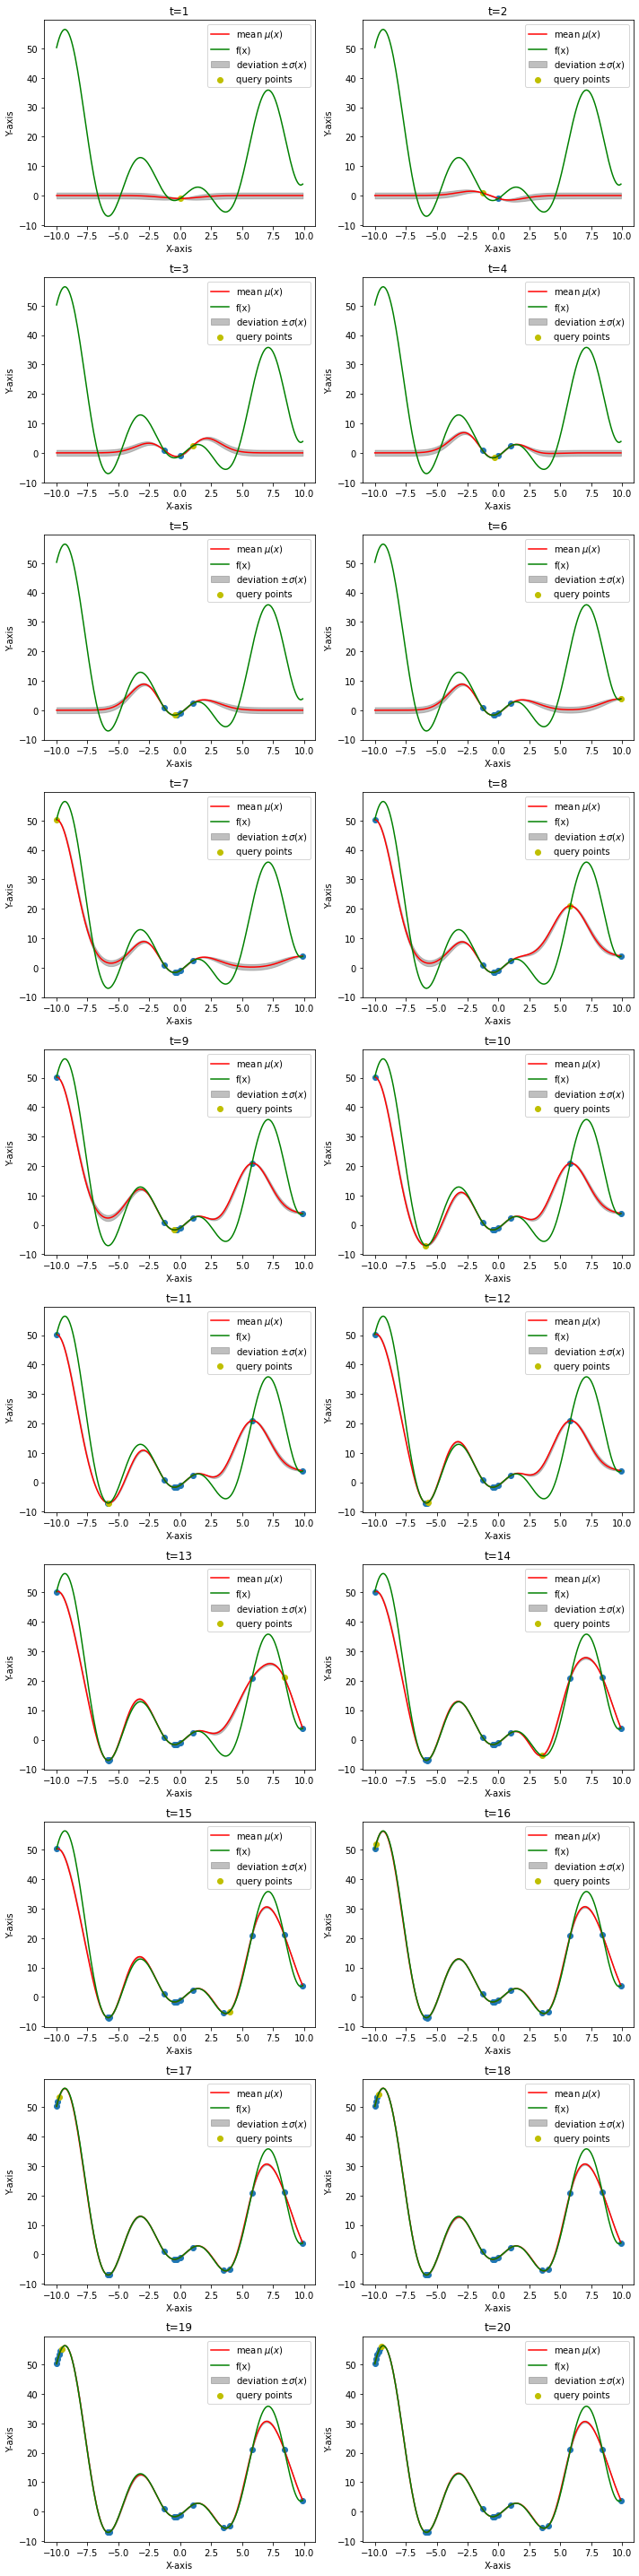

In [101]:
# Generate x values
grid_x = np.arange(-10,10,0.1)

# Create the figure and axes objects
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 40))

for i_ax in range(len(axes.flatten())):
    
    ax = axes.flatten()[i_ax]
    # Plot the mean
    ax.plot(grid_x, mu_trajectory[:,i_ax], 'r', label='mean $\mu(x)$')
    
    # Fill between mu +/- sigma
    ax.fill_between(grid_x, mu_trajectory[:,i_ax]-sigma_trajectory[:,i_ax], mu_trajectory[:,i_ax]+sigma_trajectory[:,i_ax],
                    color='gray', alpha=0.5, label='deviation $\pm \sigma(x)$')
    
    ax.scatter(observed_x[:i_ax],f(observed_x[:i_ax]))
    ax.scatter(observed_x[i_ax:i_ax+1],f(observed_x[i_ax:i_ax+1]), color='y', label='query points')
    
    ax.plot(grid_x, f(grid_x), 'g', label = "f(x)")
    
    # Setting labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('t='+str(i_ax+1))
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()